# 1D vibration of a single material point

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/geoelements/learn-mpm/blob/main/book/bar1d-vibration.ipynb)
[![Try on DesignSafe](https://img.shields.io/badge/Open%20in-DesignSafe-red.svg?logo=)](https://jupyter.designsafe-ci.org/user/name/notebooks/CommunityData/Use%20Case%20Products/MPM/LearnMPM/point-axial-vibration1d.ipynb)

Let us consider the vibration of a single material point as shown below. The bar is represented by a single point initially located at $x_p = L/2$, which has an initial velocity $v_0$. The material is linear elastic.

![bar1d](img/bar1d.png)

The exact solution for the velocity is: $v(t) = v_0 \cos (\omega t), \quad \omega = \frac{1}{L}\sqrt{E/\rho}$

and for the position is: $x(t) = x_0 \exp \left[\frac{v_0}{L \omega} \sin (\omega t)\right]$

The bar has a constant density $\rho = 1.0$. The constitutive equation is $\dot\sigma = E \dot \varepsilon$, where $\dot \varepsilon = dv/dx$ and $E$ is the Young’s modulus. The mesh consists of a single two-noded element. The elastic wave speed is $c = \sqrt{E/\rho} = 2 \pi$. The boundary conditions are imposed on the mesh, both the nodal velocity and the acceleration at $x = 0$ (the left node) is zero throughout the simulation.

## Analytical solution

In [3]:
import numpy as np

# Analytical solution
def analytical_vibration(E, rho, v0, x_loc, duration, dt, L):
    nsteps = int(duration/dt)
    tt, vt, xt = [], [], []
    t = 0
    for _ in range(nsteps):
        omega = 1. / L * np.sqrt(E / rho)
        v = v0 * np.cos(omega * t)
        x = x_loc * np.exp(v0 / (L * omega) * np.sin(omega * t))
        vt.append(v)
        xt.append(x)
        tt.append(t)
        t += dt
    return tt, vt, xt

Let's now plot the analytical solution of a vibrating bar at the end of the bar $x = 1$

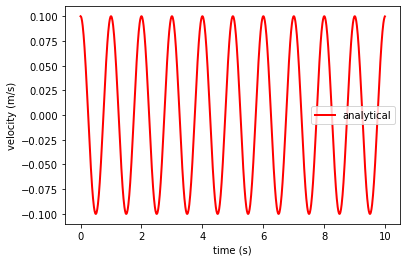

In [4]:
import matplotlib.pyplot as plt

# Young's modulus
E = 4 * (np.pi)**2

# analytical solution at the end of the bar
ta, va, xa = analytical_vibration(E = E, rho = 1, v0 = 0.1, x_loc = 1.0, duration = 10, dt = 0.01, L = 1.0)

plt.plot(ta, va, 'r',linewidth=2,label='analytical')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

## 1D MPM code - USL Scheme

We will use the Update Stress Last (USL) algorithm to implement the 1D vibrating bar example. An overview of the USL MPM algorithm is shown below:

1. Initialisation phase

    (a) Particle distribution in the undeformed configuration

    (b) Grid set up

    (c) Initialise particle quantities such as mass, stress, strain, etc.

2. Solution phase for time step $t$ to $t + \Delta t$

    (a) Mapping from particles to nodes
    
    i. Compute nodal mass: $m_i^t = \sum\limits_{p=1}^{n_P} N_i(\textbf{x}_p^t) m_p$

    ii. Compute nodal momentum: $(m \textbf{v})_i^{t} = \sum\limits_{p=1}^{n_P} N_i(\textbf{x}_p^t) m_p \textbf{v}_p^{t}$ 

    iii. Compute external force: $ (\textbf{f}_i)^{ext,t} = \textbf{b}_i^{t} + \textbf{t}_i^{t} $

    iv. Compute internal force $ (\textbf{f}_i)^{int,t} = \sum\limits_{p=1}^{n_P} V_p^t B_i(\textbf{x}_p^t) \boldsymbol{\sigma}_p^{t} $

    v. Compute nodal force: $ (\textbf{f}_i)^{tot,t} = (\textbf{f}_i)^{ext,t} + (\textbf{f}_i)^{int,t}$

    (b) Update momenta: $(m \textbf{v})_i^{t + \Delta t} = (m \textbf{v})_i^{t} +  \textbf{f}_i^{tot,t} * \Delta t$

    (c) Mapping from nodes to particles

    i. Update material point velocity: $ \textbf{v}_p^{t+\Delta t} = \sum\limits_{i=1}^{n_n} N_i(\textbf{x}_p^t) \textbf{v}_i^{t+\Delta t} $

    ii. Update material point position: $ \textbf{x}_p^{t+\Delta t} = \textbf{x}_p^t + \textbf{v}_p^{t+\Delta t} *  \Delta t$

    iii. Update nodal velocities: $\textbf{v}_i^{t + \Delta t} = (m \textbf{v})_i^{t + \Delta t} / m_i^{t}$

    iv. Calculate strain rate: $ \boldsymbol{\varepsilon}_p^t = \sum\limits_{p=1}^{n_P} B_i(\textbf{x}_p^t) \textbf{v}_i^t $

    v. Compute incremental stress based on a constitutive model $ \Delta\boldsymbol{\sigma}_p^t= \mathbf{D} : \Delta \boldsymbol{\varepsilon}_p^t $.

    vi. Compute updated stress at each material point: $ \boldsymbol{\sigma}_p^t = \boldsymbol{\sigma}_p^{t-\Delta t} + \Delta \boldsymbol{\sigma}_p^t $

3. Reset the grid and advance to the next step

### 1. Initialization phase

#### Computational domain
Let's now develop a 1D MPM code for bar vibration with a single material point in the middle of the element.

![1d bar](img/bar1dmpm.png)

The domain (bar) has a length of 1 m. We descritize the bar using a single linear element with two nodes. The left node is at 0 and the right node is at the end of the bar at L. 

In [5]:
import numpy as np
# Computational grid
L          = 1                       # domain size
nodes      = np.array([0, L])        # nodal coordinates
nnodes     = len(nodes)              # number of nodes
nelements  = 1                       # number of elements
nparticles = 1                       # number of particles
el_length  = L / nelements           # element length

print("Number of elements: {} nodal coordinates: {}, nnodes: {} nparticles: {}".
        format(nelements, nodes, nnodes, nparticles))

Number of elements: 1 nodal coordinates: [0 1], nnodes: 2 nparticles: 1


#### Material properties

We now define a linear elastic material with $E = 2 * \pi^2$ and a density $\rho = 1$.

In [6]:
# Material property
E          = 4 * (np.pi)**2          # Young's modulus
rho        = 1.                      # Density

#### Initial loading conditions

We apply an initial velocity $v_0 = 0.1$ at the material point.

In [7]:
# Initial conditions 
v0         = 0.1                     # initial velocity
x_loc      = 0.5                     # location to get analytical solution

#### Material points

In MPM, the material points keep track of the position, mass, velocity, volume, momentum and stress. The material point is at the middle of the element. The volume of the material point is the size of the entire length of the bar. Assuming a density $\rho = 1$, the mass of the material point is $\rho * L = 1 * 1 = 1.0$.

In [8]:
# Material points
x_p        = 0.5 * el_length         # position
mass_p     = 1.                      # mass
vol_p      = el_length / nparticles  # volume
vel_p      = v0                      # velocity
stress_p   = 0.                      # stress
mv_p       = mass_p * vel_p          # momentum = m * v

#### Shape functions

We will use a two-noded single element with linear elements. In order to avoid finding the natural coordinates of material points, we define the shape functions in the global coordinate system. In 1D, the shape functions are defined as: 

$N_i (x) = \begin{cases} 1 - |x - x_i|/l & \text{if } | x - x_i| \le l \\ 0 & \text{else}  \end{cases}$

where $l$ denotes the element size.

The following listings show the general shape functions and gradients for an element.

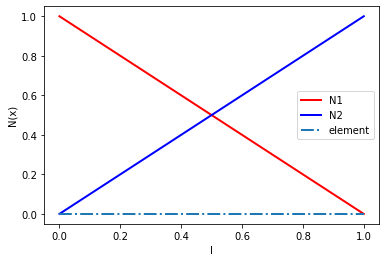

In [9]:
import matplotlib.pyplot as plt

nodes = np.array([0, L])
xs = np.arange(0, L+0.1, 0.1)
y = np.zeros_like(xs)

# shape function
n1 = [1 - abs(x - nodes[0])/L for x in xs]
n2 = [1 - abs(x - nodes[1])/L for x in xs]

plt.plot(xs, n1, 'r', linewidth=2, label='N1')
plt.plot(xs, n2, 'b', linewidth=2, label='N2')
plt.plot(xs, y, '-.', linewidth=2, label='element')
plt.xlabel('l')
plt.ylabel('N(x)')
plt.legend()
plt.show()

The derivative of the shape function is:

$B (x) = [-1/l_x, 1/l_x]$

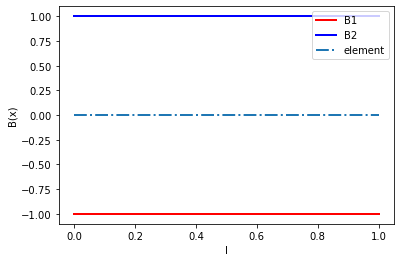

In [10]:
import matplotlib.pyplot as plt

nodes = np.array([0, L])
xs = np.arange(0, L+0.1, 0.1)
y = np.zeros_like(xs)

# shape function
b1 = [-1/L for x_p in xs]
b2 = [1/L for x_p in xs]

plt.plot(xs, b1, 'r', linewidth=2, label='B1')
plt.plot(xs, b2, 'b', linewidth=2, label='B2')
plt.plot(xs, y, '-.', linewidth=2, label='element')
plt.xlabel('l')
plt.ylabel('B(x)')
plt.legend()
plt.show()

##### Shape function for material point
We will now define the shape function and its derivatives for the material point located at $x_p$. 

In [11]:
# shape function and derivative
N     = np.array([1 - abs(x_p - nodes[0])/L, 1 - abs(x_p - nodes[1])/L])
dN    = np.array([-1/L, 1/L])

print("Shape function for material point at x_p = 0.5, is N: {}".format(N))
print("Gradient of shape function for material point at x_p = 0.5, is B: {}".format(dN))

Shape function for material point at x_p = 0.5, is N: [0.5 0.5]
Gradient of shape function for material point at x_p = 0.5, is B: [-1.  1.]


### 2. Solution phase for time step $t$ to $t + \Delta t$

#### Map mass and momentum to nodes

Mapping from particles to nodes. Let's compute the nodal mass and momentum using the linear shape functions to map  mass and velocity of the material point.

Compute nodal mass: $m_i^t = \sum\limits_{p=1}^{n_P} N_i(\textbf{x}_p^t) m_p$

Compute nodal momentum: $(m \textbf{v})_i^{t} = \sum\limits_{p=1}^{n_P} N_i(\textbf{x}_p^t) m_p \textbf{v}_p^{t}$

where,

$m_p^t$ mass of the material point $p$ at time $t$

$m\textbf{v}_p^t$ momentum of the material point $p$ at time $t$

$n_p$ total number of material points in the body

$m_i^t$ mass of node $i$ at time $t$

$m\textbf{v}_i^t$ momentum of node $i$ at time $t$

$N_i (\textbf{x}_p^t)$ shape function that maps node $i$ to material point $p$ and vice versa with independent 
variable of the location of each material point at time $t$

$B_i (\textbf{x}_p^t)$ gradient of the shape function that maps node $i$ to material point $p$ and vice versa such that $B = \frac{dN}{d\textbf{x}}$. 


________

Here, we map the mass of the particle ```mass_p``` and its momentum ```mv_p``` to both the nodes 0 and 1 of the element. The code below is equivalent to doing:

```
mass_node[0] = N[0] * mass_p
mass_node[1] = N[1] * mass_p
```

In [12]:
# map particle mass and momentum to nodes
mass_n = N * mass_p
mv_n   = N * mv_p

The mass of the particle 1.0, is split equally between both the nodes.

In [13]:
print("Mapped mass at the nodes: {}".format(mass_n))

Mapped mass at the nodes: [0.5 0.5]


Similarly, the momentum of the particle, calculated as $m_p * v_p$ is split evenly between the nodes.

In [14]:
print("Momentum at nodes: {}".format(mv_n))

Momentum at nodes: [0.05 0.05]


#### Applying boundary condition

Since the left node is fixed, we constrain the velocity at the node $v_n = 0$ for node 0. As we store momentum, rather than the velocity at the node, we constrain the momentum on the left node to be zero. 

In [15]:
# apply boundary condition: velocity at left node is zero
mv_n[0] = 0

print("Momentum at nodes after apply BCs: {}".format(mv_n))

Momentum at nodes after apply BCs: [0.   0.05]


#### Compute nodal forces

#### Compute external forces

$ (\textbf{f}_i)^{ext,t} = \textbf{b}_i^{t} + \textbf{t}_i^{t} $

where, 

$\textbf{f}_i^{ext,t}$ nodal external force of node $i$ at time $t$

$\textbf{b}_i^t$ body force of node $i$

$\textbf{f}_i^t$ nodal force of node $i$ at time $t$

In this problem, there is no external force, so we set the external forces at both nodes to be zero.

In [16]:
# external force at nodes
f_ext_n = np.array([0, 0])

print("External forces at the nodes: {}".format(f_ext_n))

External forces at the nodes: [0 0]


#### Compute internal forces

The internal force at the nodes is mapped from the particle stress: 

$ (\textbf{f}_i)^{int,t} = \sum\limits_{p=1}^{n_P} V_p^t B_i(\textbf{x}_p^t) \boldsymbol{\sigma}_p^{t} $

where, 

$\textbf{f}_i^{int,t}$ nodal internal force of node $i$ at time $t$

$V_p$ volume at material points $p$

$B_i (\textbf{x}_p^t)$ gradient of the shape function that maps node $i$ to material point $p$ and vice versa such that $B = \frac{dN}{d\textbf{x}}$

$\boldsymbol{\sigma}_p^t$ stress of material point $p$ at time $t$

____

At the start of the time step, $t = 0$, the body is unstressed $\sigma = 0$.

In [17]:
# compute internal force at nodes
f_int_n = - dN * vol_p * stress_p 

print("Internal forces at the nodes: {}".format(f_ext_n))

Internal forces at the nodes: [0 0]


#### Calculate the total unbalanced nodal forces

The total unbalanced force at the node: $ \textbf{f}_i^{tot,t} = \textbf{f}_i^{int,t} + \textbf{f}_i^{ext,t}$

-----

For this problem, the external force is zero, so the total force must equal the internal force.

In [18]:
# total forces at nodes
f_total_n = f_int_n + f_ext_n

print("Total forces at the nodes: {}".format(f_total_n))

Total forces at the nodes: [0. 0.]


We apply boundary condition on the left node, which is fixed (the velocity and acceleration are zero). Hence, we set the total force $f = m * a = 0$, since $a = 0$ at the node. 

In [19]:
# apply boundary condition: left node has no acceleration (f = m * a, and a = 0)
f_total_n[0] = 0

print("Total forces at the nodes: {}".format(f_total_n))

Total forces at the nodes: [0. 0.]


### Update nodal momentum

Nodal momentum: $ (m\textbf{v})_i^{t+\Delta t} = (m\textbf{v})_i^t + \textbf{f}_i^{tot,t} * \Delta t$

#### Critical time step
The time step $\Delta t$ must be smaller than the critical time step $\Delta t_{crit}$. Typically, $\Delta t = \Delta t_{crit}/10$.

$\Delta t_{crit} = \frac{L}{\sqrt{E \cdot \rho}}$

In [20]:
# critical time step
dt_crit = L /np.sqrt(E/rho)
print("Critical time step for an explicit simulation: {}".format(dt_crit))

Critical time step for an explicit simulation: 0.15915494309189535


We use a time step $\Delta t$ of 0.01.

In [21]:
# update nodal momentum
dt = 0.01 
mv_n += f_total_n * dt

print("Momentum at nodes: {}".format(mv_n))

Momentum at nodes: [0.   0.05]


###  Mapping from nodes to particles

#### Update particle velocities and position
Update the position of the material points based on the nodal velocity.
    
* Material point velocity:
$ \textbf{v}_p^{t+\Delta t} = \sum\limits_{i=1}^{n_n} N_i(\textbf{x}_p^t) \textbf{v}_i^{t+\Delta t} $

* Material point position:
$ \textbf{x}_p^{t+\Delta t} = \textbf{x}_p^t + \textbf{v}_p^{t+\Delta t} *  \Delta t$


In [22]:
# update particle position and velocity
for i in range(nnodes):
    vel_p += dt * N[i] * f_total_n[i] / mass_n[i]
    x_p += dt * N[i] * mv_n[i] / mass_n[i]

print("Velocity of particle: {} and position: {}".format(vel_p, x_p))

Velocity of particle: 0.1 and position: 0.5005


#### Update particle momentum

Material point momentum: $ (m\textbf{v})_p^{t+\Delta t} = m_p * \textbf{v}_p^{t+\Delta t}$

In [23]:
# update particle momentum
mv_p = mass_p * vel_p

#### Update nodal velocity

The typical equation to update nodal velocity is based on the nodal momentum: $\textbf{v}_i^{t + \Delta t} = (m \textbf{v})_i^{t + \Delta t} / m_i^{t}$.

However, we prefer to remap the particle velocity and mass and use the interpolated nodal mass to compute the nodal velocities: $(\textbf{v})_i^{t + \Delta t} = \sum\limits_{p=1}^{n_P} N_i(\textbf{x}_p^{t}) m_p \textbf{v}_p^{t + \Delta t} / m_i^{t + \Delta t}$

After updating the nodal velocity, re-constrain the velocity at the fixed node back to zero.

In [24]:
# map nodal velocity
# vel_n[0] = N[0] * mass_p * vel_p / mass_n[0]
# vel_n[1] = N[1] * mass_p * vel_p / mass_n[1]
vel_n = np.divide(N, mass_n) * mass_p * vel_p

# Apply boundary condition and set left nodal velocity to zero
vel_n[0] = 0

print("Velocity at the nodes: {}".format(vel_n))

Velocity at the nodes: [0.  0.1]


#### Compute strains and stresses
* The strain at each material point is computed by mapping the strain rate from the nodes: $ \boldsymbol{\varepsilon}_p^t = \sum\limits_{p=1}^{n_P} B_i(\textbf{x}_p^t) \textbf{v}_i^t $

* The stress at each material point is updated using $\Delta\sigma_p^t$ based on the constitutive model:
$ \boldsymbol{\sigma}_p^t = \boldsymbol{\sigma}_p^{t-\Delta t} + \Delta \boldsymbol{\sigma}_p^t $

* The incremental stress is calculated as $ \Delta\boldsymbol{\sigma}_p^t= \mathbf{D} : \Delta \boldsymbol{\varepsilon}_p^t $. In this case, we use a linear elastic model with a Young's modulus of $E$, so the stress increment $ \Delta\boldsymbol{\sigma}_p^t= E \cdot \Delta \boldsymbol{\varepsilon}_p^t $


In [25]:
# compute strain rate at the particle
# strain_rate = dN[0] * vel_n[0] + dN[1] * vel_n[1]
strain_rate_p = np.dot(dN, vel_n) 
# compute strain increament 
dstrain_p = strain_rate_p * dt
# compute stress
stress_p += E * dstrain_p

print("Strain rate: {}, dstrain: {} and stress: {} and stress: {}".format(strain_rate_p, dstrain_p, E * dstrain_p, stress_p))

Strain rate: 0.1, dstrain: 0.001 and stress: 0.039478417604357434 and stress: 0.039478417604357434


This completes all the steps in the MPM USL algorithm. These steps are repeated `n` times as shown in the full code below.

## 1D MPM code complete

Putting it all together

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Computational grid
L          = 1                       # domain size
nodes      = np.array([0, L])        # nodal coordinates
nnodes     = len(nodes)              # number of nodes
nelements  = 1                       # number of elements
nparticles = 1                       # number of particles
el_length  = L / nelements           # element length

# Initial conditions 
v0         = 0.1                     # initial velocity
x_loc      = 0.5                     # location to get analytical solution

# Material property
E          = 4 * (np.pi)**2          # Young's modulus
rho        = 1.                      # Density

# Material points
x_p        = 0.5 * el_length         # position
mass_p     = 1.                      # mass
vol_p      = el_length / nparticles  # volume
vel_p      = v0                      # velocity
stress_p   = 0.                      # stress
strain_p   = 0.                      # strain
mv_p       = mass_p * vel_p          # momentum = m * v

# Time
duration   = 10
dt         = 0.01
time       = 0
nsteps     = int(duration/dt)

# Store time, velocity and position with time
time_t, vel_t, x_t, se_t, ke_t, te_t = [], [], [], [], [], []

for _ in range(nsteps):
    # shape function and derivative
    N  = np.array([1 - abs(x_p - nodes[0])/L, 1 - abs(x_p - nodes[1])/L])
    dN = np.array([-1/L, 1/L])

    # map particle mass and momentum to nodes
    mass_n = N * mass_p
    mv_n   = N * mv_p
    
    # apply boundary condition: velocity at left node is zero
    mv_n[0] = 0

    # external force at nodes
    f_ext_n = np.array([0, 0])

    # compute internal force at nodes
    f_int_n = - dN * vol_p * stress_p 

    # total forces at nodes
    f_total_n = f_int_n + f_ext_n

    # apply boundary condition: left node has no acceleration (f = m * a, and a = 0)
    f_total_n[0] = 0

    # update nodal momentum
    mv_n += f_total_n * dt

    # update particle position and velocity
    for i in range(nnodes):
        vel_p += dt * N[i] * f_total_n[i] / mass_n[i]
        x_p += dt * N[i] * mv_n[i] / mass_n[i]

    # update particle momentum
    mv_p = mass_p * vel_p

    # map nodal velocity
    vel_n = mass_p * vel_p * np.divide(N, mass_n)
    # Apply boundary condition and set left nodal velocity to zero
    vel_n[0] = 0

    # compute strain rate at the particle
    strain_rate_p = np.dot(dN, vel_n) 
    # compute strain increament 
    dstrain_p = strain_rate_p * dt
    # compute strain
    strain_p += dstrain_p
    # compute stress
    stress_p += E * dstrain_p

    # store properties for plotting
    time_t.append(time)
    vel_t.append(vel_p)
    x_t.append(x_p)

    # Energies
    strain_energy = 0.5 * stress_p * strain_p * vol_p
    kinetic_energy = 0.5 * vel_p**2 * mass_p**2
    total_energy = strain_energy + kinetic_energy
    se_t.append(strain_energy)
    ke_t.append(kinetic_energy)
    te_t.append(total_energy)
    
    # update time
    time += dt


#### Plot results of MPM and analytical solution

Compare the MPM results with the analytical solution.

> Velocity

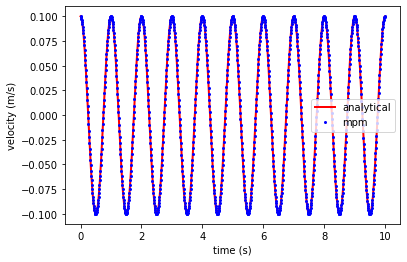

In [27]:
import matplotlib.pyplot as plt

ta, va, xa = analytical_vibration(E, rho, v0, x_loc, duration, dt, L)

plt.plot(ta, va, 'r', linewidth=2,label='analytical')
plt.plot(time_t, vel_t, 'ob', markersize = 2, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.legend()
plt.show()

> displacement

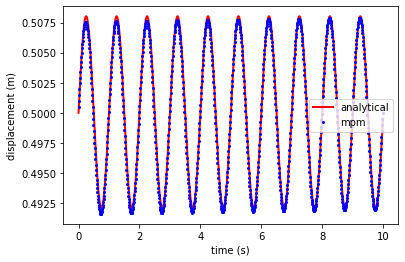

In [28]:
plt.plot(ta, xa, 'r',linewidth=2,label='analytical')
plt.plot(time_t, x_t, 'ob', markersize = 2, label='mpm')

plt.xlabel('time (s)')
plt.ylabel('displacement (m)')
plt.legend()
plt.show()

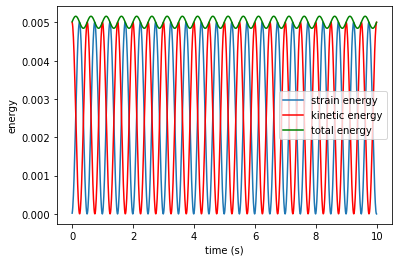

In [29]:
plt.plot(time_t, se_t, '-', markersize = 2, label='strain energy')
plt.plot(time_t, ke_t, 'r', markersize = 2, label='kinetic energy')
plt.plot(time_t, te_t, 'g', markersize = 2, label='total energy')

plt.xlabel('time (s)')
plt.ylabel('energy')
plt.legend()
plt.show()
